# CNN-based classificator

In this kernel we will build a Convolutional Neural Network (CNN) to classify the histopathological images according to the presence or less of metastatic tissue in the central 32x32 pixels area.

In [2]:
# somehow needed to make the plots visible
%matplotlib inline  

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import time 
from glob import glob 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

Using TensorFlow backend.


### Get the data
Build a dataframe with image ids and corresponding label (0 = no tumor tissue, 1 = has tumor tissue).
The images are inside the `input` folder, subdivided in training and testing images. A `.csv` file in the `input` folder provides the labels corresponding to each image id.

In [3]:
input_train_dir = 'D:/Kaggle/HistoPat/input/train/'

# the glob() function takes all elements in the train folder 
# ending with ".tif", and pandas builds a dataframe from the dict
df_data = pd.DataFrame({'path': glob(os.path.join(input_train_dir,'*.tif'))})

# create 'id' column by splitting the path string: each entry in 'path' is 
# something like "/input/train\\<image_label>.tif"; use split() method 
# on string to select only <image_label>
df_data['id'] = df_data.path.map(lambda x: x.split('\\')[1].split(".")[0])
labels = pd.read_csv("D:/Kaggle/HistoPat/input/train_labels.csv")
df_data = df_data.merge(labels, on = "id")
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

df_data.head()

,path,label
id,,
00001b2b5609af42ab0ab276dd4cd41c3e7745b5,D:/Kaggle/HistoPat/input/train\00001b2b5609af4...,1
000020de2aa6193f4c160e398a8edea95b1da598,D:/Kaggle/HistoPat/input/train\000020de2aa6193...,0
00004aab08381d25d315384d646f5ce413ea24b1,D:/Kaggle/HistoPat/input/train\00004aab08381d2...,0
0000d563d5cfafc4e68acb7c9829258a298d9b6a,D:/Kaggle/HistoPat/input/train\0000d563d5cfafc...,0
0000da768d06b879e5754c43e2298ce48726f722,D:/Kaggle/HistoPat/input/train\0000da768d06b87...,1


We now create the train and validation dataframes

In [4]:
df_data = shuffle(df_data)

y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

df_train['label'].value_counts()
df_val['label'].value_counts()

(198022, 2)
(22003, 2)


0    13091
1     8912
Name: label, dtype: int64

So far we have created dataframes with only the image index and the corresponding labels. We won't load into memory all the images at the same time, to avoid the kernel dying. Instead, the images will be copied in different subfolders for training and validation, each with two subfolders corresponding to the two classes. The structure looks like this:
 - base_dir
     - train_dir
         - a_no_tumor_tissue
         - b_has_tumor_tissue
     - val_dir
         - a_no_tumor_tissue
         - b_has_tumor_tissue

In [ ]:
# Create a new base directory
base_dir = 'D:/Kaggle/HistoPat/base_dir'
os.mkdir(base_dir)

# create training and testing directories inside 
# of the base directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create two directories inside of train_dir
no_tumor_tissue = os.path.join(train_dir, 'No_tumor_Class_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'Tumor_Class_1')
os.mkdir(has_tumor_tissue)

# create two directories inside of val_dir
no_tumor_tissue = os.path.join(val_dir, 'No_tumor_Class_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'Tumor_Class_1')
os.mkdir(has_tumor_tissue)

And now we copy the images in the corresponding directories (this might take a while)

In [ ]:
# Get a list of image indexes for training
# and validation images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Copy train images
for image in train_list:
    
    filename = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # sort them according to their label
    if target == 0:
        label = 'No_tumor_Class_0'
    if target == 1:
        label = 'Tumor_Class_1'
    
    # source path to image
    src = os.path.join('D:/Kaggle/HistoPat/input/train', filename)
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Copy val images
for image in val_list:
    
    filename = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # sort them according to their label
    if target == 0:
        label = 'No_tumor_Class_0'
    if target == 1:
        label = 'Tumor_Class_1'
    
    # source path to image
    src = os.path.join('.D:/Kaggle/HistoPat/input/train', filename)
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

### Data pre-processing

Now that our data is sorted the way we need it, we can perform some data augmentation. In this way the network will be trained with different versions of the same images (e.g. rotated images, mirrored images, zoom-ins, etc.), thus allowing for more robust predictions.

In [5]:
# Define some useful quantities
train_path = 'D:/Kaggle/HistoPat/base_dir/train_dir'
valid_path = 'D:/Kaggle/HistoPat/base_dir/val_dir'
test_path = 'D:/Kaggle/HistoPat/input/test'

img_size = 96

train_batch_size = 32
val_batch_size = 32

We use Keras' `ImageDataGenerator` class to create generators, i.e. objects which take a batch of images as input and perform different pre-processing operations on them.

In [6]:
# this function normalizes the pixel values in order for
# them to have zero mean and unitary standard deviation.
# This favours the convergence of the learning procedure
def normalize_image(x):
    if x.std() > 0:
        return (x - x.mean())/x.std()
    else:
        return x

datagen = ImageDataGenerator(preprocessing_function=normalize_image,
                             rotation_range=10,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2,
                             )

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


We define a different generator which we use to evaluate the performance of the model after training. It is probably not the optimal way to do it, since we use the same validation set which will be used during training to adjust the model parameters (e.g. early stopping and learning rate reduction). Another way would be to separate the validation set into two parts (TODO).

In [7]:
# shuffle=False because we need the images
# sorted properly to compare the model's 
# predictions with the true labels
eval_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 22003 images belonging to 2 classes.


#### Check pre-processing
It is generally a good idea to have a look at how the images are being pre-processed by the `ImageDataGenerator`, to be sure that the modifications do not alter severly the original images.

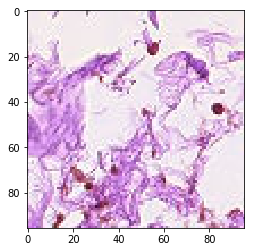

In [19]:
# let's take one random image (depending how you sorted 
# training and validation sets this image might be in 
# either of the two)
image_path = 'D:/Kaggle/HistoPat/base_dir/train_dir/No_tumor_Class_0/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif'

img = cv2.imread(image_path)
plt.imshow(img)
plt.show()

This is how a normal image looks like. Now what happens after pre-processing?

In [20]:
# for the sake of RGB plotting we define another generator with
# same arguments, except the normalization function, which is not
# used here.
datagen_plot = ImageDataGenerator(rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  zoom_range=0.2,
                                  )
# reshape image in the appropriate format
img = img.reshape((1,)+img.shape)

plot_gen = datagen_plot.flow(img)

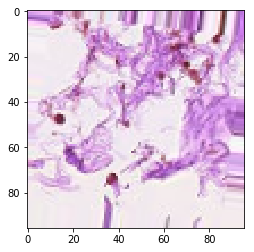

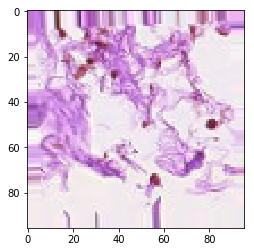

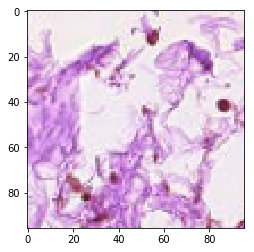

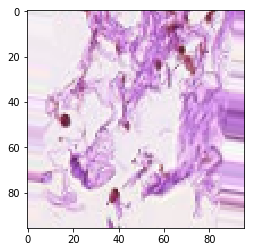

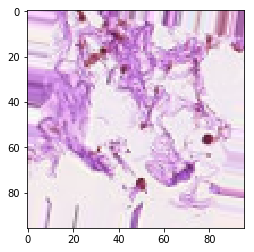

In [21]:
num_examples = 5
for i in range(0,num_examples):
    x_batch = next(plot_gen)
    image = x_batch[0]
    image = image/255.
    plt.imshow(image)
    plt.show()

When the images are rotated by a large angle, one gets some ugly lines on the outer part of the images. One way to get rid of them would be to crop the images afterwards, also because we are interested in detecting tumor tissue only on the central 32x32 pixels area (TODO).

### Build the model
We are now ready to build our CNN. The architechture for this model is taken from Francesco Marazzi's kernel for the same competition: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

In [8]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

### Training phase
We will use `ReduceLROnPlateau` to scale down the optimizer's learning rate when the validation loss does not improve any further. We will also use `EarlyStopping` when also such reduction of learning rate does not produce an improvement on the validation loss, to avoid heavy overfitting

In [ ]:
epochs = 16
train_steps = len(df_train) // train_batch_size
val_steps = len(df_val) // val_batch_size

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights_CNN_v01_200KEX.hdf5', 
                               verbose=1, save_best_only=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)

start = time.time()

history = model.fit_generator(train_gen,
                             steps_per_epoch=train_steps, 
                             validation_data=val_gen,
                             validation_steps=val_steps,
                             epochs=epochs,
                             callbacks=[reducel, early_stopping, checkpointer])
#plot accuracies 
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='r')
plt.title('Model Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation accuracy'], loc='best')
plt.show()

#plot losses
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.title('Model Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')
plt.show()

end = time.time()
print("Elapsed time for training: " + str((end - start)//60) + " minutes.")

Epoch 1/16


### Model evaluation
Although we have used the accuracy metric so far, in this Kaggle competition the used score is based on the Area Under Curve (AUC), which is the area of the Receiver Operating Characteristic (ROC) Curve.

In [ ]:
#model.load_weights('weights_CNN_v01_200KEX.hdf5')

# predict the probability for the two classes for each of the images in the
# validation set
y_pred_val = model.predict_generator(eval_gen, verbose=1, steps=len(df_val))

# calculate false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, _ = roc_curve(eval_gen.classes, y_pred_val)

# get AUC score
auc = auc(fpr, tpr)
auc

We can also plot the ROC curve

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Useful kernels: 
Francesco Marazzi, Baseline Keras CNN

https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb 

Marsh, CNN - How to use 160,000 images without crashing

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing